In [12]:
import cv2
import mediapipe as mp
import os
import cv2
import numpy as np
import dlib
import pandas as pd
import re
import time
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import glob
from alibabacloud_facebody20191230.client import Client
from alibabacloud_facebody20191230.models import DetectFaceAdvanceRequest
from alibabacloud_tea_openapi.models import Config
from alibabacloud_tea_util.models import RuntimeOptions
from PIL import Image

# Facial detection algorithm (Alibaba Cloud)

## Facial land marks

In [30]:
def face_reg_alibabacloud(pic_path):
    config = Config(
    # 创建AccessKey ID和AccessKey Secret，请参考https://help.aliyun.com/document_detail/175144.html
    # 从环境变量读取配置的AccessKey ID和AccessKey Secret。运行代码示例前必须先配置环境变量。
    access_key_id=os.environ.get('ALIBABA_CLOUD_ACCESS_KEY_ID'),
    access_key_secret=os.environ.get('ALIBABA_CLOUD_ACCESS_KEY_SECRET'),
    # 访问的域名
    endpoint='facebody.cn-shanghai.aliyuncs.com',
    # 访问的域名对应的region
    region_id='cn-shanghai')

    detect_face_request = DetectFaceAdvanceRequest()

    # 文件在本地
    stream = open(pic_path, 'rb')
    detect_face_request.image_urlobject = stream
    detect_face_request.landmark = True
    detect_face_request.quality = True
    detect_face_request.pose = False
    detect_face_request.max_face_number = 1

    runtime = RuntimeOptions()

    # 初始化Client
    client = Client(config)
    response = client.detect_face_advance(detect_face_request, runtime)
    # 获取识别结果
    result = dict()
    result['body'] = response.body.to_map()
    face_info = result['body'].get('Data')
    # print(face_info)
    # print(face_info.get('FaceRectangles'))
    # 返回人脸矩形框，分别是[left, top, width, height]
    FaceRectangles = face_info.get('FaceRectangles')
    # 返回人脸特征点定位结果，每个人脸返回一组特征点位置，表示方式为（x0, y0, x1, y1, ……），如有多个人脸，则依次顺延，返回定位浮点数。
    # LandmarkCount人脸特征点数目，目前固定为105点。依次为：眉毛24点，眼睛32点，鼻子6点，嘴巴34点，外轮廓9点
    Landmarks = face_info.get('Landmarks')

    time.sleep(1)

    return FaceRectangles, Landmarks

In [31]:
def draw_rectangle_and_landmarks(img_path, img_save_patn):
    image = cv2.imread(img_path)
    # 计算面部区域的边界框
    x_min, x_max = float('inf'), float('-inf')
    y_min, y_max = float('inf'), float('-inf')
    F, L = face_reg_alibabacloud(img_path)
    # 将表示方式转换为坐标对列表
    landmarks = [(int(L[i]), int(L[i + 1])) for i in range(0, len(L), 2)]
    
    for landmark in landmarks:
        x, y = int(landmark[0]), int(landmark[1])
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
    
    # 绘制面部关键点索引
    for idx, landmark in enumerate(landmarks):
        x, y = int(landmark[0]), int(landmark[1])
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)
        cv2.putText(image, str(idx + 1), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        
        
    cv2.imwrite(img_save_patn, image)
    print('save img success!')

## Facial Region Crop

In [44]:

FaceRectangles, Landmarks = face_reg_alibabacloud(os.path.join(me_crop_path, me_sample, 'onset.png'))
onset_image = cv2.imread(os.path.join(me_crop_path, me_sample, 'onset.png'))

# print('shape:', onset_image.shape)
# print('FaceRectangles[0]:', FaceRectangles[0])
# print('FaceRectangles[1]:', FaceRectangles[1])
# print('FaceRectangles[2]:', FaceRectangles[2])
# print('FaceRectangles[3]:', FaceRectangles[3])

# cv2.rectangle(onset_image, (FaceRectangles[0], FaceRectangles[1]), (FaceRectangles[0]+FaceRectangles[2], FaceRectangles[1]+FaceRectangles[3]), (0, 255, 0), 2)

# 裁剪面部区域
face_roi = onset_image[FaceRectangles[1]: FaceRectangles[1]+FaceRectangles[3],
                      FaceRectangles[0]: FaceRectangles[0]+FaceRectangles[2]]


cv2.imwrite(img_save_patn, face_roi)
print('save img success!')

shape: (1088, 2048, 3)
FaceRectangles[0]: 764
FaceRectangles[1]: 353
FaceRectangles[2]: 545
FaceRectangles[3]: 647


In [47]:
def get_face_roi(src_img, img_save_path):
    FaceRectangles, Landmarks = face_reg_alibabacloud(os.path.join(me_crop_path, me_sample, src_img))
    image = cv2.imread(os.path.join(me_crop_path, me_sample, src_img))

    # 裁剪面部区域
    face_roi = image[FaceRectangles[1]: FaceRectangles[1]+FaceRectangles[3],
                     FaceRectangles[0]: FaceRectangles[0]+FaceRectangles[2]]


    cv2.imwrite(img_save_path, face_roi)
    print('save img success!')
        
get_face_roi('onset.png', 'aliyun_onset_cropped.jpg')        
get_face_roi('apex.png', 'aliyun_apex_cropped.jpg') 

save img success!
save img success!


# Facial region segmentation, cropping, and alignment

## Segmenting facial regions based on color and area thresholds

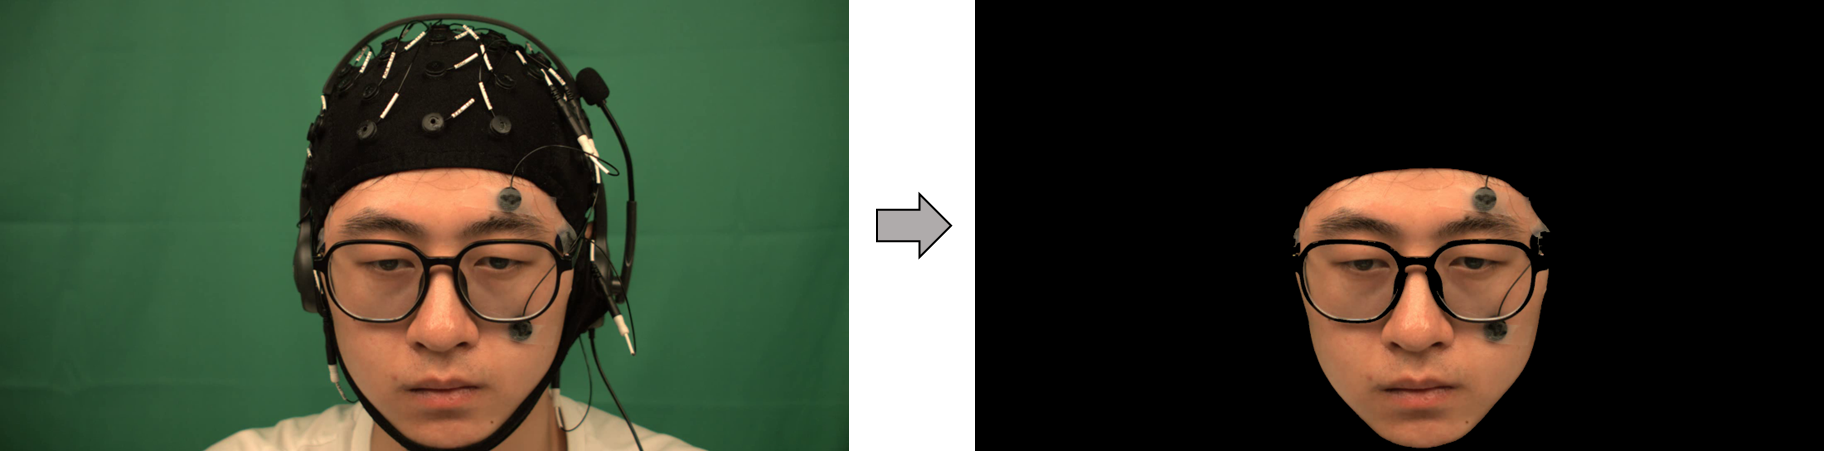

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

exp_type = 'Micro'

In [2]:
def segmented_face(pic_crop_path, pic_segment_path, sample, exp_type):
    # 加载图像
    for filename in os.listdir(os.path.join(pic_crop_path, sample)):
        image_path = os.path.join(pic_crop_path, sample, filename)
        print('image_path:', image_path)
        raw_image = cv2.imread(image_path)

        # 获取图像高度
        image_height = raw_image.shape[0]

        # 转换图像为HSV颜色空间
        hsv_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2HSV)

        # 定义用于分割的颜色范围（例子是皮肤颜色范围）
        lower_color = np.array([0, 48, 80], dtype=np.uint8)
        upper_color = np.array([20, 255, 255], dtype=np.uint8)

        # 基于定义的颜色范围创建掩码
        mask = cv2.inRange(hsv_image, lower_color, upper_color)

        # 使用形态学操作闭操作填补小孔
        kernel = np.ones((5, 5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

        # 找到掩码中的轮廓
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 打印找到的轮廓数量
        print(f"Number of contours found: {len(contours)}")

        # 创建一个新的掩码用于过滤后的轮廓
        filtered_mask = np.zeros_like(mask)

        # 定义一个面积阈值，用于过滤掉小区域
        area_threshold = 20000  # 根据需要调整这个阈值

        # 质心接近图片高度的阈值
        height_threshold = 0.75 * image_height  # 例如，图片高度的80%

        # 过滤轮廓
        valid_contours = []
        for contour in contours:
            area = cv2.contourArea(contour)
            if area > area_threshold:
                # 计算轮廓的质心
                M = cv2.moments(contour)
                if M["m00"] != 0:
                    cx = int(M["m10"] / M["m00"])
                    cy = int(M["m01"] / M["m00"])
                else:
                    cx, cy = 0, 0

                # 过滤掉质心y坐标接近图片高度的轮廓
                if cy < height_threshold:
                    # 分割接触较小的轮廓
                    split_contours = split_touching_contours(contour)
                    valid_contours.extend(split_contours)

        # 打印过滤后的轮廓数量
        print(f"Number of filtered contours: {len(valid_contours)}")

        # 在新的掩码上绘制过滤后的轮廓
        for contour in valid_contours:
            cv2.drawContours(filtered_mask, [contour], -1, (255), thickness=cv2.FILLED)

        # 将过滤后的掩码应用到原始图像上
        segmented_image = cv2.bitwise_and(raw_image, raw_image, mask=filtered_mask)

        # 用红线绘制分割和过滤后的轮廓
#         result_image = segmented_image.copy()
#         for contour in valid_contours:
#             cv2.drawContours(result_image, [contour], -1, (0, 0, 255), thickness=2)

        # 保存分割后的图像
        output_path = os.path.join(pic_segment_path, exp_type, sample)
        os.makedirs(output_path, exist_ok=True)
        output_pic_path = os.path.join(output_path, filename)
        cv2.imwrite(output_pic_path, segmented_image)
        print(f"Segmented image saved to {output_pic_path}")

        # 保存绘制轮廓后的图像
#         output_contour_path = os.path.join(output_path, filename)
#         cv2.imwrite(output_contour_path, result_image)
#         print(f"Contour image saved to {output_contour_path}")
        print('-------------------------------------------------------------------------')

In [7]:
import cv2
import numpy as np

def split_touching_contours(mask):
    """
    分离相互接触的轮廓
    :param mask: 输入的二值化掩码图像
    :return: 分离后的轮廓列表
    """
    # 确保掩码是二值化的，并且数据类型为 uint8
    if mask.dtype != np.uint8:
        mask = mask.astype(np.uint8)

    # 对掩码进行形态学膨胀操作
    kernel = np.ones((5, 5), np.uint8)  # 选择一个合适的内核大小
    dilated_mask = cv2.dilate(mask, kernel, iterations=1)

    # 找到膨胀后的轮廓
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 创建一个新的空白图像以绘制分离的轮廓
    separated_mask = np.zeros_like(mask)

    # 遍历所有轮廓，绘制到空白图像中
    for contour in contours:
        cv2.drawContours(separated_mask, [contour], -1, 255, thickness=cv2.FILLED)

    # 进行腐蚀操作，以增强轮廓之间的分离
    eroded_mask = cv2.erode(separated_mask, kernel, iterations=1)

    # 找到腐蚀后的轮廓
    final_contours, _ = cv2.findContours(eroded_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    return final_contours

# 示例使用
# 假设有一个二值化的掩码图像 'mask'
# mask = cv2.imread('path_to_binary_mask', cv2.IMREAD_GRAYSCALE)  # 确保读取为灰度图
# mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)[1]  # 确保是二值化
# final_contours = split_touching_contours(mask)


In [4]:
pic_select_path = os.path.join('1.pics_selected', exp_type)
os.makedirs(pic_select_path, exist_ok=True)

pic_segment_path = '2.pics_selected_segmented'

for sample in os.listdir(pic_select_path):
    segmented_face(pic_select_path, pic_segment_path, sample, exp_type)

## Crop the facial area to (256, 256)

- 存入3.pics_selected_segmented_cropped

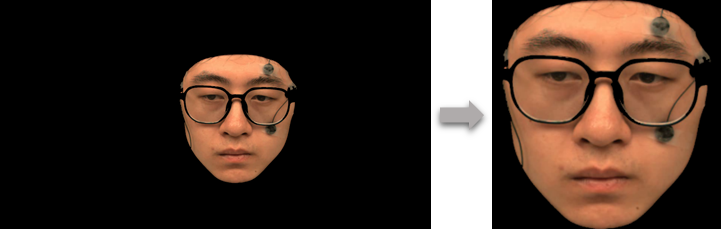

In [5]:
def crop_and_pad_face(segmented_path, crop_path, sample, exp_type, target_size=(256, 256)):
    # Load the image
    for filename in os.listdir(os.path.join(segmented_path, sample)):
        image_path = os.path.join(segmented_path, sample, filename)
        print('image_path:', image_path)
        image = cv2.imread(image_path)

        # Convert image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)

        # Find contours in the mask
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # If no contours found, return None
        if len(contours) == 0:
            print("No contours found in the image")
            return

        # Merge contours if there are more than one
        if len(contours) > 1:
            contours_combined = np.vstack(contours)
            x, y, w, h = cv2.boundingRect(contours_combined)
        else:
            x, y, w, h = cv2.boundingRect(contours[0])

        # Crop the image using the bounding box coordinates
        cropped_image = image[y:y+h, x:x+w]

        # Calculate padding to maintain aspect ratio
        height, width, _ = cropped_image.shape
        target_width, target_height = target_size
        if width > height:
            pad_top = (width - height) // 2
            pad_bottom = width - height - pad_top
            pad_left = 0
            pad_right = 0
        else:
            pad_left = (height - width) // 2
            pad_right = height - width - pad_left
            pad_top = 0
            pad_bottom = 0

        # Apply padding
        padded_image = cv2.copyMakeBorder(cropped_image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

        # Resize the padded image to the target size
        resized_image = cv2.resize(padded_image, target_size, interpolation=cv2.INTER_AREA)
        
        # 保存裁剪后的图像
        output_path = os.path.join(crop_path, exp_type, sample)
        os.makedirs(output_path, exist_ok=True)
        output_pic_path = os.path.join(output_path, filename)
        cv2.imwrite(output_pic_path, resized_image)

In [6]:
exp_type = 'Micro'

segment_path = os.path.join('2.pics_selected_segmented', exp_type)

crop_path = '3.pics_selected_segmented_cropped'

for sample in os.listdir(segment_path):
    crop_and_pad_face(segment_path, crop_path, sample, exp_type, target_size=(256, 256))

image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_1.70_1.97_2.20\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_1.70_1.97_2.20\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_10.06_10.25_10.50\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_10.06_10.25_10.50\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_41.29_41.57_41.76\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_liyan20230802_116_41.29_41.57_41.76\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\onset.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\apex.png
image_path: 2.pics_selected_segmented\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\onset.png
image_path: 2.pics_selected_segment

image_path: 2.pics_selected_segmented\Micro\disgust_fengdengfang20230802_110_36.50_36.63_36.77\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_fengdengfang20230802_112_41.42_41.81_41.99\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_fengdengfang20230802_112_41.42_41.81_41.99\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_liyan20230802_112_46.24_46.60_46.60\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_liyan20230802_112_46.24_46.60_46.60\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangshuai20230802_119_7.45_7.80_7.89\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangshuai20230802_119_7.45_7.80_7.89\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangxiaomin20230718_102_52.90_53.15_53.15\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangxiaomin20230718_102_52.90_53.15_53.15\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_wangxiaomin20230718_110_15.32_15.57

image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.01_21.34_21.51\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.01_21.34_21.51\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.21_21.33_21.46\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_21.21_21.33_21.46\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_24.18_24.44_24.61\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_24.18_24.44_24.61\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.75_3.96_4.22\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.75_3.96_4.22\onset.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.85_4.02_4.20\apex.png
image_path: 2.pics_selected_segmented\Micro\disgust_zhaoshaohua20230801_110_3.

image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.89_2.06_2.23\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.89_2.06_2.23\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.95_2.10_2.34\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_1.95_2.10_2.34\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.22_14.47_14.55\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.22_14.47_14.55\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.24_14.41_14.74\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_14.24_14.41_14.74\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_17.54_17.71_17.88\apex.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20230728_121_17.54_17.71_17.88\onset.png
image_path: 2.pics_selected_segmented\Micro\fear_yangmi20

image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_120_35.28_35.53_35.75\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_120_35.28_35.53_35.75\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_40.05_40.30_40.30\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_40.05_40.30_40.30\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_53.51_53.76_53.76\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yangmi20230728_129_53.51_53.76_53.76\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_120_6.60_7.33_7.33\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_120_6.60_7.33_7.33\onset.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_123_4.90_5.20_5.20\apex.png
image_path: 2.pics_selected_segmented\Micro\happy_yansen20230731_123_4.90_5.20_5.20\onset.png
image_path: 2.pics_selected_segmented\Micro\hap

image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_44.34_44.53_44.53\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_44.34_44.53_44.53\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_7.70_7.90_7.90\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_127_7.70_7.90_7.90\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_17.81_18.01_18.30\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_17.81_18.01_18.30\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.44_19.76_20.00\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.44_19.76_20.00\onset.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.54_19.77_19.98\apex.png
image_path: 2.pics_selected_segmented\Micro\sad_wangxiaomin20230718_136_19.54_19.77_19.98\onset.png
image_path:

image_path: 2.pics_selected_segmented\Micro\surprise_wangshuai20230802_126_11.32_11.46_11.75\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangshuai20230802_126_25.05_25.20_25.20\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangshuai20230802_126_25.05_25.20_25.20\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangziheng20230727_147_50.82_50.90_51.03\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangziheng20230727_147_50.82_50.90_51.03\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_108_12.28_12.48_12.79\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_108_12.28_12.48_12.79\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_126_18.68_18.90_18.90\apex.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717_126_18.68_18.90_18.90\onset.png
image_path: 2.pics_selected_segmented\Micro\surprise_wangzishan20230717

## Facial alignment

### Align the tip of the nose

In [32]:
# 计算鼻子质心
def calculate_nose_centroid(landmarks):
    points_nose = np.array([[landmarks[i][0], landmarks[i][1]] for i in range(58, 63)])
    return points_nose.mean(axis=0)

# 应用仿射变换对图像进行质心对齐
def align_images_by_nose_centroid(src_image, src_landmarks, dst_image, dst_landmarks):
    src_nose_centroid = calculate_nose_centroid(src_landmarks)
    dst_nose_centroid = calculate_nose_centroid(dst_landmarks)

    # 计算平移向量
    tx = dst_nose_centroid[0] - src_nose_centroid[0]
    ty = dst_nose_centroid[1] - src_nose_centroid[1]

    # 创建平移矩阵
    M_translation = np.float32([[1, 0, tx], [0, 1, ty]])

    # 获取目标图像的尺寸
    h, w = dst_image.shape[:2]

    # 应用平移变换
    aligned_image = cv2.warpAffine(src_image, M_translation, (w, h))

    return aligned_image

def get_align_image(onset_path, apex_path, aligned_onset_path):
    onset = cv2.imread(onset_path)
    apex = cv2.imread(apex_path)
    
    F_onset, L_onset = face_reg_alibabacloud(onset_path)
    # 将表示方式转换为坐标对列表
    landmarks_onset = [(int(L_onset[i]), int(L_onset[i + 1])) for i in range(0, len(L_onset), 2)]
    
    F_apex, L_apex = face_reg_alibabacloud(apex_path)
    # 将表示方式转换为坐标对列表
    landmarks_apex = [(int(L_apex[i]), int(L_apex[i + 1])) for i in range(0, len(L_apex), 2)]

    # 质心对齐
    onset_aligned = align_images_by_nose_centroid(onset, landmarks_onset, apex, landmarks_apex)

    # 保存质心对齐后的图像到文件
    cv2.imwrite(aligned_onset_path, onset_aligned)

    print(f'{aligned_onset_path}')
    print('align_image success！')

- 首先将'3.pics_selected_segmented_cropped'中的onset.png和apex.png复制到'4.pics_selected_segmented_cropped_align'，然后在'4.pics_selected_segmented_cropped_align'中产生对齐的align_onset_by_nose.png

In [33]:
exp_type = 'Micro'
# exp_type = 'Macro'

source_path = os.path.join('3.pics_selected_segmented_cropped', exp_type)
aligned_path = os.path.join('4.pics_selected_segmented_cropped_align', exp_type)

for sample in os.listdir(source_path):
    onset_path = os.path.join(source_path, sample, 'onset.png')
    apex_path = os.path.join(source_path, sample, 'apex.png')
    
    # 如果两个图片均存在
    if os.path.exists(onset_path) and os.path.exists(apex_path): 
        os.makedirs(os.path.join(aligned_path, sample), exist_ok=True)
        # 复制并重命名文件
        shutil.copy2(onset_path, os.path.join(aligned_path, sample, 'onset.png'))
        shutil.copy2(apex_path, os.path.join(aligned_path, sample, 'apex.png'))

        # 获取对齐后的align_onset_by_nose.png，并存入aligned_onset_path
        aligned_onset_path = os.path.join(aligned_path, sample, 'align_onset_by_nose.png')
        get_align_image(onset_path, apex_path, aligned_onset_path)
    else:
        print('onset.png或apex.png不存在！')
    
#     try:
#         os.remove(os.path.join(aligned_path, sample, 'aligned_onset.png'))
#     except:
#         pass

4.pics_selected_segmented_cropped_align\Micro\angry_liyan20230802_116_1.70_1.97_2.20\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_liyan20230802_116_10.06_10.25_10.50\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_liyan20230802_116_41.29_41.57_41.76\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangshuai20230802_107_28.25_28.50_28.70\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangshuai20230802_107_29.44_29.84_29.84\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangshuai20230802_142_17.51_17.67_17.97\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wangxiaomin20230718_116_39.78_40.00_40.00\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\angry_wa

4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_20.00_20.17_20.30\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_27.71_27.90_28.13\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_27.81_27.91_28.04\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_41.25_41.50_41.67\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_41.33_41.52_41.74\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_42.45_42.70_42.70\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\disgust_yangmi20230728_110_46.45_46.65_46.85\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\di

4.pics_selected_segmented_cropped_align\Micro\fear_wangxiaomin20230718_134_18.63_18.79_18.96\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_15.34_15.51_15.69\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_29.97_30.23_30.45\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_42.38_42.55_42.73\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_104_42.42_42.60_42.77\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_113_39.55_39.73_39.98\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\fear_wangziheng20230727_121_31.19_31.27_31.53\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\

4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_23.80_24.05_24.05\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_38.52_38.72_38.90\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_41.04_41.20_41.44\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_41.11_41.27_41.42\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaolei20230803_123_9.48_9.72_9.72\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaoshaohua20230801_103_11.56_11.81_11.81\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happy_zhaoshaohua20230801_103_11.85_12.18_12.35\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\happ

4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_118_40.25_40.45_40.45\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_118_5.12_5.25_5.46\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_118_5.13_5.23_5.38\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_127_17.96_18.05_18.23\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_136_11.79_11.98_12.07\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_136_30.85_31.13_31.32\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\sad_zhaoshaohua20230801_148_23.26_23.50_23.50\align_onset_by_nose.png
align_image success！
4.pics_selected_segmented_cropped_align\Micro\s

- sad_zhengwansheng20230718_118_20.24_20.44_20.74 对齐后效果不好

# Calculate optical flow and optical strain

In [25]:
import cv2
import numpy as np
import os
import shutil

def read_image(path):
    """
    读取图像并将其转换为灰度图像。
    """
    img = cv2.imread(path)  # 读取图像
    if img is None:  # 检查图像是否读取成功
        raise FileNotFoundError(f"Image not found at path: {path}")
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # 转换为灰度图像
    return img, gray_img

# 计算光流
def compute_TVL1(prev, curr, bound=15):
    TVL1 = cv2.optflow.DualTVL1OpticalFlow_create()  # 创建TV-L1光流对象
    flow = TVL1.calc(prev, curr, None)  # 计算光流
    assert flow.dtype == np.float32  # 确保光流的数据类型是float32

    flow = (flow + bound) * (255.0 / (2 * bound))  # 将光流归一化到0-255范围内
    flow = np.round(flow).astype(np.float32)  # 将光流取整并转换为float32类型
    flow[flow >= 255] = 255  # 将超过255的值截断为255
    flow[flow <= 0] = 0  # 将低于0的值截断为0

    return flow

# 计算光应变
def generate_optical_strain(flow):
    u = flow[...,0]
    v = flow[...,1]

    ux, uy = np.gradient(u)
    vx, vy = np.gradient(v)

    e_xy = 0.5*(uy + vx)
    e_xx = ux
    e_yy = vy
    e_m = e_xx ** 2 + 2 * e_xy ** 2 + e_yy ** 2
    e_m = np.sqrt(e_m)
    e_m = cv2.normalize(e_m, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    e_m = e_m.astype(np.uint8)

    return e_m

# 生成光流图像及其水平和垂直分量、光应变
def generate_optical_flow(sample_path):
    onset = os.path.join(sample_path, 'align_onset_by_nose.png')
    apex = os.path.join(sample_path, 'apex.png')
    
    of_path = os.path.join(sample_path, 'OF.png')
    os_path = os.path.join(sample_path, 'OS.png')
    horz_path = os.path.join(sample_path, 'H.png')
    vert_path = os.path.join(sample_path, 'V.png')
    
    onset_img, onset_img_gray = read_image(onset)  # 读取初始图像及其灰度图像
    apex_img, apex_img_gray = read_image(apex)  # 读取顶点图像及其灰度图像
    
    flow = compute_TVL1(onset_img_gray, apex_img_gray)  # 计算光流

    # 创建一个基于初始图像的空HSV图像
    hsv = np.zeros_like(onset_img)
    hsv[..., 1] = 255  # 设置饱和度为255

    # 计算光流的幅值和方向
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2  # 方向角度
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)  # 幅值归一化
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)  # 转换为BGR图像

    # 计算光流的水平和垂直分量
    horz = cv2.normalize(flow[..., 0], None, 0, 255, cv2.NORM_MINMAX)
    vert = cv2.normalize(flow[..., 1], None, 0, 255, cv2.NORM_MINMAX)
    horz = horz.astype('uint8')  # 转换为uint8类型
    vert = vert.astype('uint8')  # 转换为uint8类型

    # 生成光应变（注释掉的部分，假设有这个函数）
    optical_strain = generate_optical_strain(flow)

    # 保存生成的图像
    cv2.imwrite(of_path, rgb)
    cv2.imwrite(os_path, optical_strain)
    cv2.imwrite(horz_path, horz)
    cv2.imwrite(vert_path, vert)
    
    print(f'generate optical flow success!: {sample_path}')

In [35]:
# exp_type = 'Micro'
exp_type = 'Macro'

source_path = os.path.join('4.pics_selected_segmented_cropped_align', exp_type)
opticalflow_path = os.path.join('5.pics_selected_segmented_cropped_align_opticalflow', exp_type)

for sample in os.listdir(source_path):
    onset_path = os.path.join(source_path, sample, 'align_onset_by_nose.png')
    apex_path = os.path.join(source_path, sample, 'apex.png')
    
    os.makedirs(os.path.join(opticalflow_path, sample), exist_ok=True)
    
    # 复制并重命名文件
    shutil.copy2(onset_path, os.path.join(opticalflow_path, sample, 'align_onset_by_nose.png'))
    shutil.copy2(apex_path, os.path.join(opticalflow_path, sample, 'apex.png'))
    
    sample_path = os.path.join(opticalflow_path, sample)
    generate_optical_flow(sample_path)

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_107_19.06_19.44_19.70
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_142_16.80_17.17_17.44
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_142_3.00_3.19_3.63
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_fengdengfang20230802_146_24.33_24.59_25.33
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_liyan20230802_125_48.70_49.15_49.15
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_wangshuai20230802_107_40.37_40.67_41.66
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_wangshuai20230802_125_35.95_36.66_37.46
generate optical flow success!: 5.pics_sele

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_wangzishan20230717_142_17.60_18.36_19.83
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_xietao20230803_146_34.87_35.46_35.46
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_107_24.14_24.88_24.88
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_107_24.44_24.85_25.65
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_116_14.08_14.54_15.10
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_116_14.20_14.40_15.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\angry_yangmi20230728_116_21.16_21.46_21.83
generate optical flow success!: 5.pics_selected_segmented_cropped

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_34.80_35.28_38.64
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_38.77_39.18_39.45
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_40.10_40.44_40.44
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_110_40.22_40.39_40.82
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_112_37.65_38.50_38.91
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_119_4.45_4.96_4.96
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_wangxiaomin20230718_119_4.46_5.08_5.08
generate optical flow succ

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_102_51.15_51.40_51.71
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_20.91_22.10_22.10
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_28.90_29.30_29.30
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_4.40_4.91_5.63
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_110_4.55_4.89_4.89
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_112_23.80_24.38_24.63
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhaoshaohua20230801_112_23.80_24.42_25.05
generate optical flow succ

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_3.13_3.76_3.76
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_35.68_35.95_36.22
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_40.05_40.41_40.41
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_128_45.50_45.95_45.95
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_137_1.26_1.53_1.53
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\disgust_zhengwansheng20230718_137_22.48_23.00_23.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_fengdengfang20230802_104_26.26_26.70_26.97
generate optical

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_134_32.61_33.30_34.27
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_134_7.81_8.31_8.31
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_14.62_15.15_16.45
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_16.14_16.49_17.10
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_19.14_20.53_22.09
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_19.20_19.89_19.89
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\fear_zhengwansheng20230718_139_19.98_20.50_21.19
generate optical flow success!

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_19.09_19.66_19.66
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_26.84_27.78_27.78
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_43.34_44.00_44.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_43.45_44.76_44.76
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_56.26_57.11_57.11
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_7.62_8.09_8.93
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_wangxiaomin20230718_138_7.67_8.05_8.05
generate optical flow success!: 5.pics_s

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_31.70_33.03_34.28
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_32.61_33.19_33.61
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_34.28_35.03_35.03
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_111_34.69_35.11_35.27
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_120_6.60_6.96_7.79
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_129_37.08_38.29_40.30
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_yansen20230731_129_37.16_38.54_40.70
generate optical flow success!: 5.pics_selected_segmented_cropped_align_

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_42.17_42.73_43.67
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_55.45_56.56_56.56
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_55.92_56.58_56.58
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\happy_zhengwansheng20230718_138_57.53_58.94_58.94
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_fengdengfang20230802_136_46.06_46.72_47.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_linjiaying20230719_101_46.04_47.17_48.68
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_lizhuoru20230720_101_13.38_14.12_16.96
generate optical flow success!: 5.p

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_25.78_26.06_26.06
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_25.79_26.13_26.13
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_36.23_36.98_36.98
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_118_9.30_9.91_9.91
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\sad_zhengwansheng20230718_127_46.68_46.96_46.96
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\surprise_wangxiaomin20230718_108_32.28_33.76_33.76
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\surprise_wangxiaomin20230718_117_39.00_39.36_40.00
generate optical flow success!:

generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\tense_zhaoshaohua20230801_114_10.50_10.80_11.38
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\tense_zhengwansheng20230718_105_26.18_26.63_27.00
generate optical flow success!: 5.pics_selected_segmented_cropped_align_opticalflow\Macro\tense_zhengwansheng20230718_122_54.89_55.19_55.61


# Generate features and labels

In [26]:
from torch.utils.data import TensorDataset, DataLoader
import torch
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import os
import pandas as pd
import cv2
import numpy as np

## get dataset

In [27]:
def get_dataset(opticalflow_path):
    dataset = {"X": [],  "y": [], "subject": []}

    for sample in os.listdir(opticalflow_path):
        label = sample.split('_')[0]
        subject = ''.join(filter(str.isalpha, sample.split('_')[1])) # 提取字符串中的字母部分，"liyan20230802"—>"liyan"

        of_path = os.path.join(opticalflow_path, sample, 'OF.png')
        os_path = os.path.join(opticalflow_path, sample, 'OS.png')
        horz_path = os.path.join(opticalflow_path, sample, 'H.png')
        vert_path = os.path.join(opticalflow_path, sample, 'V.png')

        dataset['X'].append((of_path, os_path, horz_path, vert_path))
        dataset['y'].append(label)
        dataset['subject'].append(subject)
    
    return dataset

In [28]:
# exp_type = 'Micro'
exp_type = 'Macro'
# exp_type = 'Ma+Mi'

label_map = {'angry': 0, 'surprise': 1, 'fear': 2, 'sad': 3, 'disgust': 4, 'tense': 5, 'happy': 6}
label_emotions = list(label_map.keys())
print('label_emotions:',label_emotions)

opticalflow_path = os.path.join('5.pics_selected_segmented_cropped_align_opticalflow', exp_type)

dataset_TAIIC = get_dataset(opticalflow_path)

label_emotions: ['angry', 'surprise', 'fear', 'sad', 'disgust', 'tense', 'happy']


In [29]:
# 统计每种情绪的频率
emotion_counts = Counter(dataset_TAIIC["y"])
# 将Counter对象转换为字典
counter_dict = dict(emotion_counts)
ordered_dict = dict(OrderedDict((key, counter_dict[key]) for key in label_emotions))
print('ordered_dict:', ordered_dict)

# 计算样本总数
total_sum = sum(ordered_dict.values())
print('total_sum:', total_sum)

ordered_dict: {'angry': 105, 'surprise': 26, 'fear': 67, 'sad': 62, 'disgust': 141, 'tense': 32, 'happy': 172}
total_sum: 605


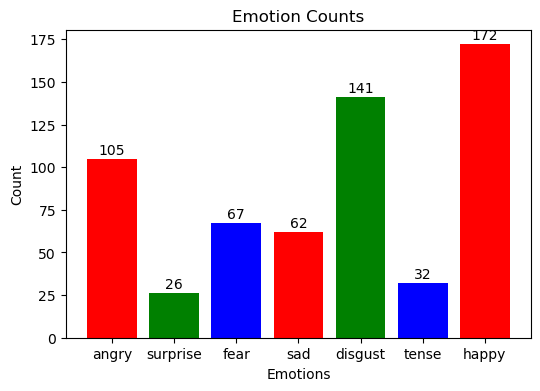

In [30]:
# 提取情绪标签及其数量
emotion_labels = list(ordered_dict.keys())
emotion_values = list(ordered_dict.values())

# 绘制柱状图
plt.figure(figsize=(6, 4))
bars = plt.bar(emotion_labels, emotion_values, color=['red', 'green', 'blue'])

# 在柱状图上显示数量
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Emotions')
plt.ylabel('Count')
plt.title('Emotion Counts')
plt.show()

In [31]:
subjects_list = list(set(dataset_TAIIC['subject']))
print('subjects_list:', subjects_list)

subjects_list: ['zhangbuyuan', 'zhaolei', 'zhengwansheng', 'yangmi', 'yansen', 'zhangdi', 'fengdengfang', 'linjiaying', 'lizhuoru', 'liyan', 'wangxiaomin', 'wangziheng', 'zhaoshaohua', 'wangzishan', 'xietao', 'wangshuai']


## network

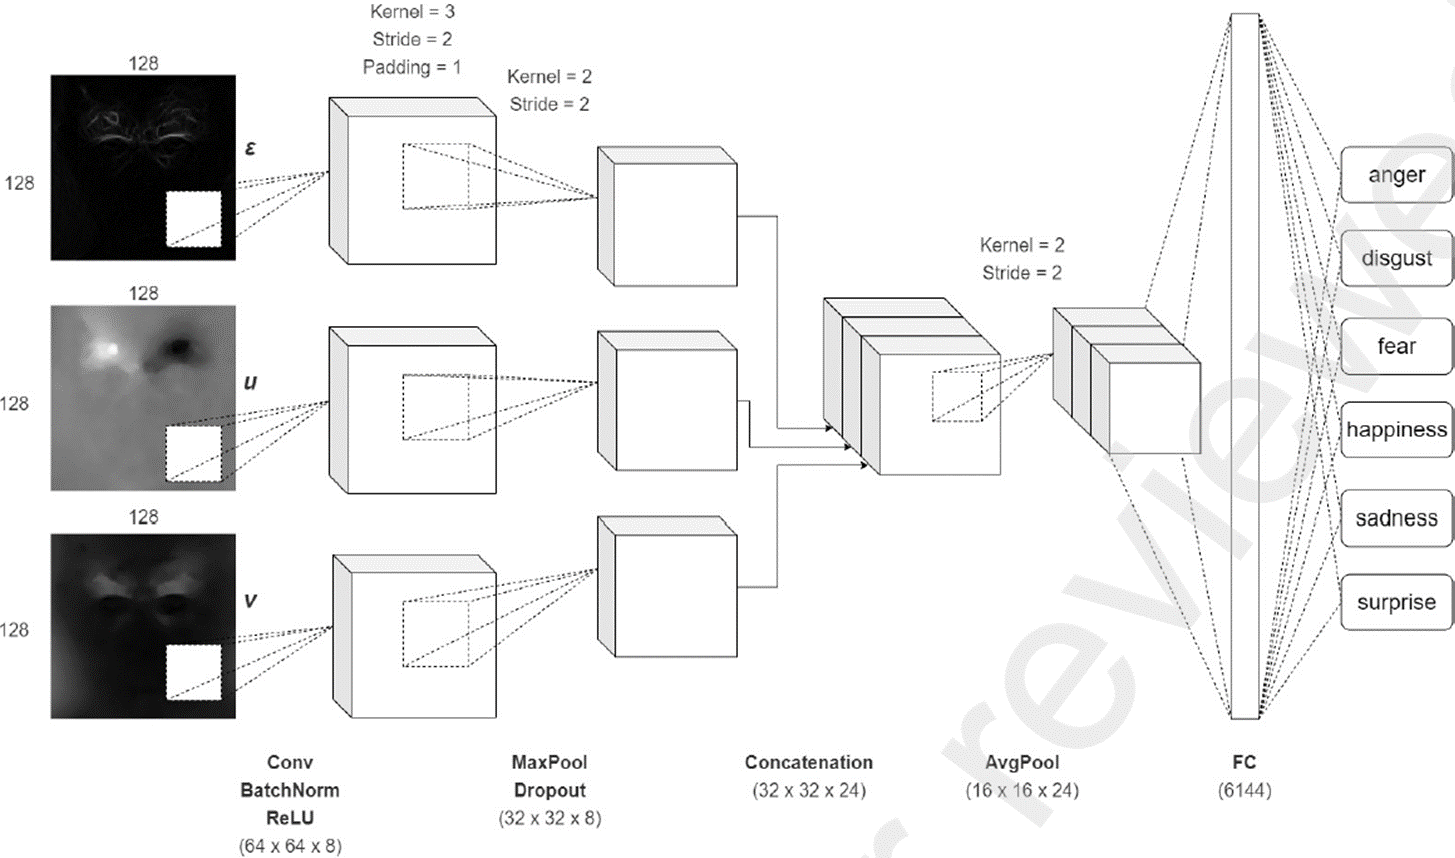

In [32]:
class MER(nn.Module):
    def __init__(self, in_channels=1, num_classes=7):
        super(MER, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=8, kernel_size=3, stride=2, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.batch_norm = nn.BatchNorm2d
        self.fc = nn.Linear(in_features=24576, out_features=num_classes)
        
        self.conv_layer1 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer2 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )

        self.conv_layer3 = nn.Sequential(
            self.conv1, self.batch_norm(8), self.relu, self.max_pool, self.dropout
        )
    
    def forward(self, x):
        os, h, v = x
        x1 = self.conv_layer1(os)
        x2 = self.conv_layer2(h)
        x3 = self.conv_layer3(v)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.avg_pool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [37]:
import torch
import torch.nn as nn
import torchvision.models as models

class MER_resnet18(nn.Module):
    def __init__(self, in_channels=1, num_classes=7):
        super(MER_resnet18, self).__init__()
        # 加载预训练的ResNet18模型
        resnet18 = models.resnet18(pretrained=True)
        
        self.features = resnet18
        # 移除最后一层以获取特征
        # self.features = torch.nn.Sequential(*list(resnet18.children())[:-1])
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=24576, out_features=num_classes)
        
    def forward(self, x):
        os, h, v = x
        print('os.shape:', os.shape) # os.shape: torch.Size([128, 1, 256, 256])
        img = np.array([os, h, v]).cpu()
        x = self.features(img)
#         x1 = self.features(os)
#         x2 = self.features(h)
#         x3 = self.features(v)
#         x = torch.cat((x1, x2, x3), dim=1)
        x = self.avg_pool(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

# model training

In [14]:
def get_numerical_labels(emotion_list):
    label_map = {'angry': 0, 'surprise': 1, 'fear': 2, 'sad': 3, 'disgust': 4, 'tense': 5, 'happy': 6}
    # 使用列表推导式进行替换
    y_data_mapped = [label_map[emotion] for emotion in emotion_list]
    
    return y_data_mapped

In [15]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [16]:
def compute_f1_recall(real, pred):
    TN, FP, FN, TP = confusion_matrix(real, pred).ravel()
    if 2 * TP + FP + FN == 0:
        f1_score = 0
    else:
        f1_score = 2 * TP / (2 * TP + FP + FN)

    if real.count(1) == 0:
        recall = 0
    else:
        recall = TP / real.count(1)
    
    return f1_score, recall

In [17]:
def evaluation_metrics(real, pred, emotions):
    f1_list = []
    recall_list = []
    for i, emotion in enumerate(emotions):
        y_real = [1 if i == j else 0 for j in real]
        y_pred = [1 if i == j else 0 for j in pred]

        try:
            f1, recall = compute_f1_recall(y_real, y_pred)
            f1_list.append(f1)
            recall_list.append(recall)
        except Exception as e:
            print(e)
    
    uf1 = np.mean(f1_list)
    uar = np.mean(recall_list)

    return uf1, uar

In [18]:
def generate_dataloader(X, y, batch_size):
    X_data = []
    y_data = []

    g = torch.Generator() # 创建一个PyTorch的随机数生成器g
    g.manual_seed(0) # 将其种子设为0，以确保数据加载的可重复性

    # 遍历输入数据 X 和标签 y
    for (of, os, h, v), y in zip(X, y):
        # 以灰度模式读取图像文件
        of = cv2.imread(of, cv2.IMREAD_GRAYSCALE)
        os = cv2.imread(os, cv2.IMREAD_GRAYSCALE)
        h = cv2.imread(h, cv2.IMREAD_GRAYSCALE)
        v = cv2.imread(v, cv2.IMREAD_GRAYSCALE)

        # 将读取的三个图像 os、h 和 v 组合成一个 numpy 数组 img
        img = np.array([os, h, v])
        
        # 确保 img 的形状为 (3, 256, 256)
        if img.shape == (3, 256, 256):
            X_data.append(img)
            y_data.append(y)
        else:
            print(f"Unexpected image shape: {img.shape}")
    
    # 将 X_data 和 y_data 转换为 numpy 数组，然后进一步转换为 PyTorch 张量
    X_tensor = torch.Tensor(np.array(X_data))
    y_tensor = torch.Tensor(y_data).to(dtype=torch.long)

    # 使用 X_tensor 和 y_tensor 创建一个 TensorDataset，它是 PyTorch 数据集的一种类型
    tensor_dataset = TensorDataset(X_tensor, y_tensor)

    data_loader = DataLoader(tensor_dataset, 
                            batch_size=batch_size, # 在训练期间以指定的 batch_size 提供数据
                            shuffle=True, # shuffle=True 表示每个 epoch 之后打乱数据
                            num_workers=0, # num_workers=4 表示使用4个子进程来加载数据
                            worker_init_fn=seed_worker, # 设置数据加载的随机种子，以确保可重复性
                            generator=g)

    return data_loader

## losocv

In [34]:
def generate_losocv_dataset(dataset, subject, out_dir, label_emotions, visualize=True):
    train_X = []
    train_y = []
    test_X = []
    test_y = []

    for x, y, s in zip(dataset['X'], dataset['y'], dataset['subject']):
        if subject == s:
            test_X.append(x)
            test_y.append(y)
        else:
            train_X.append(x)   
            train_y.append(y)

    if visualize:
        train_set = []
        test_set = []
        for i, emo in enumerate(label_emotions):
            train_set.append(train_y.count(emo))
            test_set.append(test_y.count(emo))

        df = pd.DataFrame({
            'train': train_set,
            'test': test_set
        }, index=label_emotions)

        fig, ax = plt.subplots(figsize=(6, 4))
        ax = df.plot.bar(rot=0, ax=ax)
        for container in ax.containers:
            ax.bar_label(container)

        ax.set_title('Data Distribution')
        plt.savefig(f"{out_dir}/data_distribution_{subject}.png")
        plt.show()
        plt.close(fig)
    
    # 将字符串的情绪类型转为数字
    train_y = get_numerical_labels(train_y)
    test_y = get_numerical_labels(test_y)
    
    return train_X, train_y, test_X, test_y

In [39]:
def train_locosv(epochs, lr, batch_size, out_dir, label_emotions):
    subjects = list(set(dataset_TAIIC['subject']))
    
    actual = []
    predicted = []
    uf1_history = []
    uar_history = []
    accuracy_history = []
    num_correct = 0
    total_sample = 0
    
    cm_df = None
    
    f = open('Train results/FULL_logs_loso.txt', 'a')
    
    
    for i, subject in enumerate(subjects):
    #     f.write(f'Subject ({i+1}/{len(subjects)}): {subject}\n')
        print(f'Subject ({i+1}/{len(subjects)}): {subject}')

        train_X, train_y, test_X, test_y = generate_losocv_dataset(dataset_TAIIC, subject, out_dir, label_emotions)
        train_loader = generate_dataloader(train_X, train_y, batch_size=batch_size)
        test_loader = generate_dataloader(test_X, test_y, batch_size=batch_size)
        
        model = MER().to(device)
#         model = MER_resnet18().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # TRAINING
        model.train()
        
        for epoch in range(epochs):
            for batch, y in train_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                optimizer.zero_grad()
                y_hat = model.forward((os, h, v))
                loss = criterion(y_hat, y)

                loss.backward()
                optimizer.step()
                
        # TESTING
        model.eval()
        with torch.no_grad():
            y_preds = torch.Tensor().to(device)
            y_test = torch.Tensor().to(device)

            for batch, y in test_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                y_hat = model.forward((os, h, v))
                y_hat = torch.argmax(y_hat, dim=1)
                y_preds = torch.cat((y_preds, y_hat), dim=0)
                y_test = torch.cat((y_test, y), dim=0)
            
            y_test = y_test.to('cpu')
            y_preds = y_preds.to('cpu')
            f.write(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}\n')
            f.write(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}\n')
            print(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}')
            print(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}')
            
            cm = confusion_matrix(y_test, y_preds, labels=range(7))
            if type(cm_df) != pd.DataFrame:
                cm_df = pd.DataFrame(cm, index=label_emotions, columns=label_emotions)
            else:
                cm_df = cm_df.add(pd.DataFrame(cm, index=label_emotions, columns=label_emotions))
            
            num_correct += (y_preds == y_test).sum().item()
            total_sample += len(y_test)
            accuracy = num_correct / total_sample
            accuracy_history.append(accuracy)

            actual.extend(y_test.tolist())
            predicted.extend(y_preds.tolist())

            uf1, uar = evaluation_metrics(actual, predicted, label_emotions)
            uf1_history.append(uf1)
            uar_history.append(uar)

            f.write(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}\n')
            f.write('=========================================================\n')
            print(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
            print('=========================================================')

True
Subject (1/16): zhangbuyuan


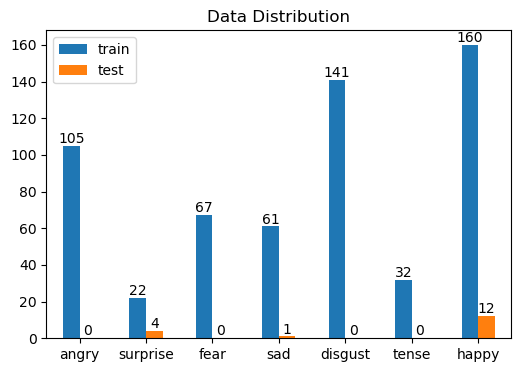

Ground Truth:	[3, 6, 1, 6, 6, 6, 6, 6, 1, 6, 6, 1, 6, 1, 6, 6, 6]
Predicted:	[0, 6, 0, 6, 6, 6, 6, 6, 0, 0, 6, 1, 6, 0, 6, 6, 6]
not enough values to unpack (expected 4, got 1)
not enough values to unpack (expected 4, got 1)
not enough values to unpack (expected 4, got 1)
[OVERALL] Accuracy: 0.7059 | UF1 score: 0.3391 | UAR score: 0.2917
Subject (2/16): zhaolei


D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


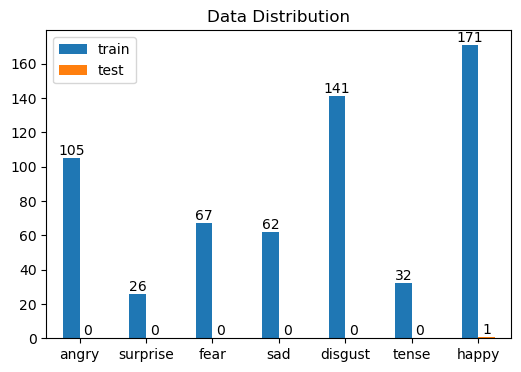

Ground Truth:	[6]
Predicted:	[4]
not enough values to unpack (expected 4, got 1)
not enough values to unpack (expected 4, got 1)
[OVERALL] Accuracy: 0.6667 | UF1 score: 0.2633 | UAR score: 0.2192
Subject (3/16): zhengwansheng


D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
D:\ProgramData\Anaconda3\envs\TF_2G\lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


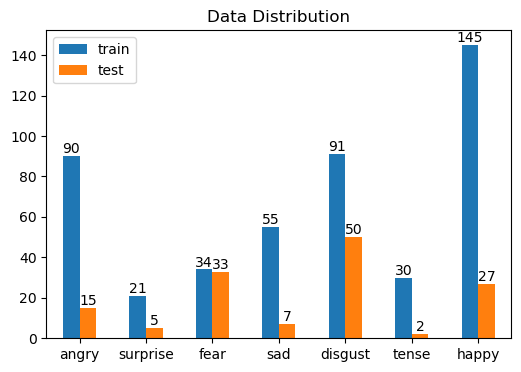

Ground Truth:	[2, 6, 6, 4, 4, 4, 3, 2, 6, 2, 2, 6, 4, 2, 0, 2, 4, 4, 4, 5, 4, 2, 4, 6, 6, 2, 4, 6, 6, 6, 0, 3, 6, 1, 2, 4, 2, 2, 3, 2, 5, 2, 2, 2, 4, 4, 1, 0, 0, 4, 2, 6, 0, 0, 2, 4, 4, 0, 3, 6, 1, 2, 4, 0, 6, 4, 1, 2, 6, 4, 3, 4, 6, 6, 4, 2, 2, 2, 4, 4, 0, 4, 0, 4, 6, 4, 2, 0, 4, 2, 4, 2, 6, 2, 0, 2, 0, 0, 6, 2, 6, 4, 6, 0, 6, 4, 3, 4, 4, 6, 6, 2, 4, 4, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2, 2, 4, 4, 6, 1, 4, 4, 4, 6, 6, 2]
Predicted:	[6, 6, 6, 6, 4, 4, 6, 6, 4, 4, 5, 4, 6, 4, 0, 5, 4, 4, 6, 4, 6, 6, 4, 6, 6, 2, 0, 5, 6, 6, 4, 4, 0, 2, 5, 4, 2, 4, 4, 6, 4, 2, 5, 4, 4, 5, 2, 4, 4, 4, 4, 6, 4, 4, 5, 4, 4, 4, 4, 6, 4, 4, 4, 0, 6, 2, 6, 4, 6, 4, 6, 4, 6, 6, 0, 6, 5, 5, 6, 6, 6, 4, 0, 4, 6, 6, 5, 6, 6, 4, 4, 2, 2, 4, 4, 4, 0, 6, 6, 2, 0, 4, 6, 0, 6, 6, 0, 6, 6, 6, 4, 6, 4, 4, 4, 4, 6, 6, 4, 6, 6, 4, 4, 4, 6, 6, 4, 5, 4, 6, 4, 6, 0, 4, 4, 6, 6, 6, 2]
[OVERALL] Accuracy: 0.4522 | UF1 score: 0.2761 | UAR score: 0.2802
Subject (4/16): yangmi


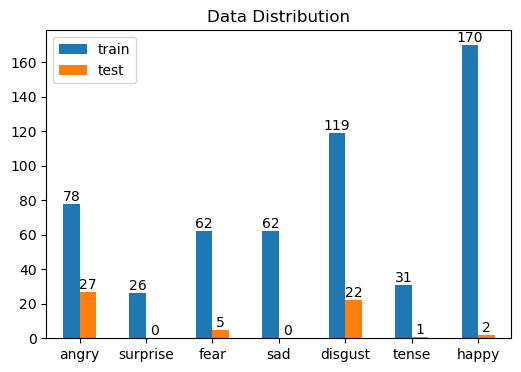

Ground Truth:	[4, 0, 0, 6, 4, 5, 4, 4, 0, 0, 0, 0, 0, 4, 4, 0, 4, 2, 0, 0, 2, 0, 0, 4, 6, 0, 0, 4, 4, 4, 4, 4, 2, 0, 0, 4, 4, 0, 0, 0, 4, 0, 0, 4, 0, 4, 0, 4, 0, 0, 2, 4, 4, 2, 4, 0, 0]
Predicted:	[2, 2, 0, 5, 0, 2, 0, 5, 5, 5, 4, 0, 4, 0, 0, 0, 0, 2, 0, 0, 2, 1, 4, 0, 3, 0, 1, 4, 4, 4, 0, 2, 0, 0, 0, 0, 0, 4, 1, 5, 4, 5, 0, 4, 0, 4, 1, 5, 5, 1, 0, 4, 6, 4, 2, 4, 4]
[OVERALL] Accuracy: 0.4206 | UF1 score: 0.2691 | UAR score: 0.2719
Subject (5/16): yansen


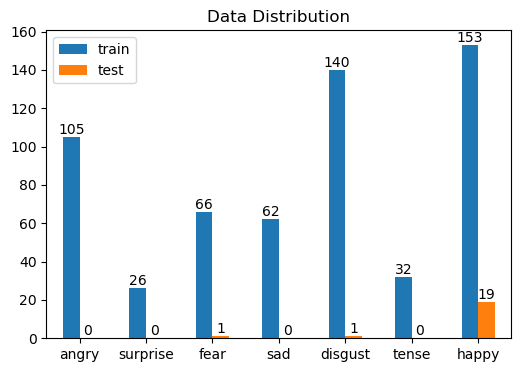

Ground Truth:	[6, 2, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6]
Predicted:	[6, 2, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 0, 6, 6, 6, 6]
[OVERALL] Accuracy: 0.4553 | UF1 score: 0.2813 | UAR score: 0.2784
Subject (6/16): zhangdi


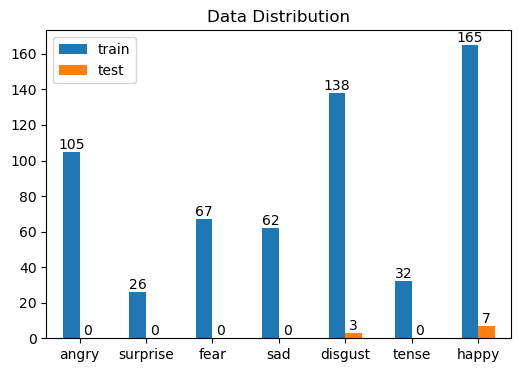

Ground Truth:	[6, 6, 6, 4, 4, 6, 4, 6, 6, 6]
Predicted:	[6, 6, 6, 4, 0, 6, 5, 6, 6, 6]
[OVERALL] Accuracy: 0.4694 | UF1 score: 0.2850 | UAR score: 0.2810
Subject (7/16): fengdengfang


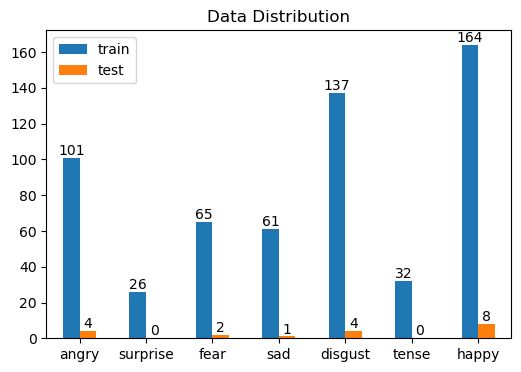

Ground Truth:	[0, 4, 4, 6, 6, 2, 6, 4, 6, 6, 6, 3, 0, 2, 6, 6, 0, 0, 4]
Predicted:	[4, 4, 4, 2, 1, 6, 4, 5, 6, 4, 6, 6, 4, 6, 6, 6, 4, 6, 6]
[OVERALL] Accuracy: 0.4583 | UF1 score: 0.2748 | UAR score: 0.2707
Subject (8/16): linjiaying


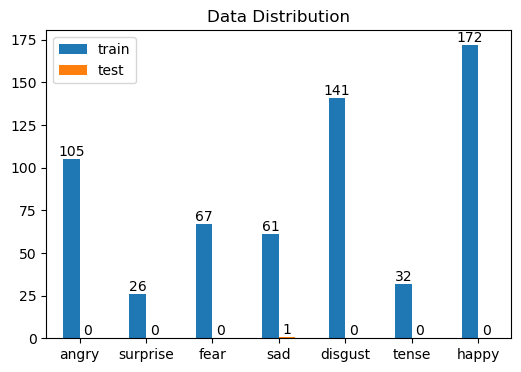

Ground Truth:	[3]
Predicted:	[4]
[OVERALL] Accuracy: 0.4566 | UF1 score: 0.2743 | UAR score: 0.2707
Subject (9/16): lizhuoru


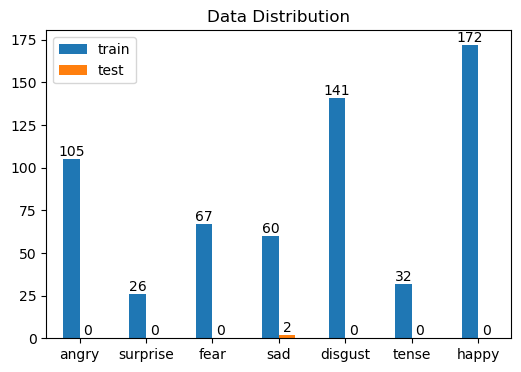

Ground Truth:	[3, 3]
Predicted:	[2, 5]
[OVERALL] Accuracy: 0.4532 | UF1 score: 0.2736 | UAR score: 0.2707
Subject (10/16): liyan


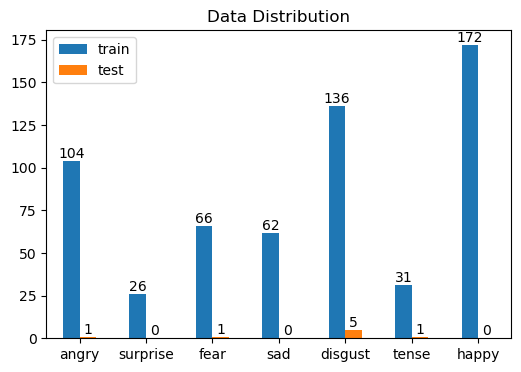

Ground Truth:	[4, 4, 4, 5, 4, 2, 4, 0]
Predicted:	[6, 6, 6, 6, 6, 6, 4, 6]
[OVERALL] Accuracy: 0.4436 | UF1 score: 0.2679 | UAR score: 0.2666
Subject (11/16): wangxiaomin


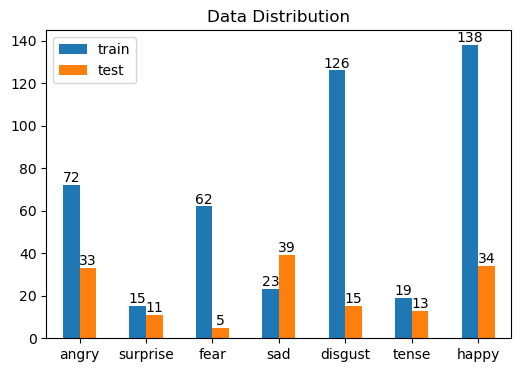

Ground Truth:	[6, 3, 3, 3, 3, 3, 6, 4, 5, 6, 4, 4, 3, 0, 3, 6, 3, 6, 0, 5, 6, 3, 0, 3, 6, 3, 4, 6, 6, 4, 3, 6, 0, 3, 6, 3, 3, 3, 0, 5, 1, 3, 1, 0, 3, 6, 2, 6, 3, 4, 3, 1, 6, 0, 5, 6, 4, 2, 6, 6, 2, 6, 6, 1, 1, 2, 5, 0, 6, 0, 5, 3, 3, 5, 6, 3, 3, 3, 1, 1, 1, 5, 0, 0, 6, 0, 3, 3, 0, 0, 2, 3, 6, 0, 1, 0, 4, 5, 4, 5, 0, 6, 3, 0, 1, 6, 0, 1, 0, 0, 6, 6, 4, 0, 0, 0, 3, 3, 6, 3, 4, 5, 3, 0, 0, 3, 6, 3, 3, 0, 0, 6, 4, 4, 0, 4, 0, 5, 0, 4, 6, 0, 6, 6, 0, 3, 3, 5, 6, 3]
Predicted:	[6, 6, 6, 0, 2, 0, 6, 6, 2, 6, 4, 0, 0, 4, 4, 6, 0, 3, 6, 2, 6, 4, 2, 0, 6, 4, 4, 6, 6, 0, 0, 3, 0, 0, 5, 4, 3, 0, 6, 2, 0, 0, 4, 0, 2, 3, 4, 6, 3, 5, 0, 4, 6, 2, 4, 6, 0, 0, 6, 6, 2, 6, 6, 0, 4, 2, 4, 4, 6, 4, 4, 0, 4, 4, 6, 4, 4, 0, 0, 4, 6, 0, 6, 2, 6, 2, 4, 2, 1, 2, 1, 2, 6, 6, 1, 0, 0, 2, 4, 4, 4, 6, 6, 4, 1, 6, 0, 4, 0, 6, 3, 6, 6, 0, 3, 0, 0, 3, 6, 2, 0, 0, 6, 4, 2, 4, 6, 6, 0, 2, 4, 3, 0, 4, 4, 6, 1, 0, 0, 4, 6, 0, 6, 6, 4, 6, 6, 0, 6, 6]
[OVERALL] Accuracy: 0.4024 | UF1 score: 0.2749 | UAR score: 0.2807
Subjec

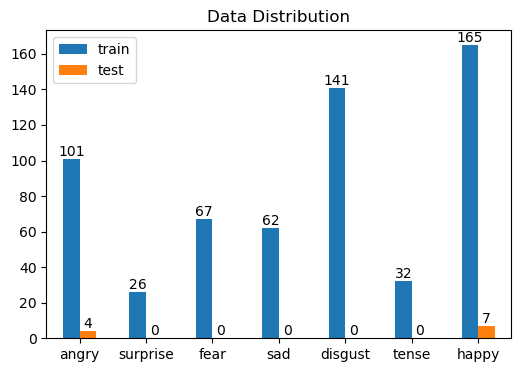

Ground Truth:	[0, 0, 6, 6, 6, 0, 6, 6, 6, 0, 6]
Predicted:	[4, 6, 6, 4, 0, 4, 6, 6, 6, 4, 6]
[OVERALL] Accuracy: 0.4037 | UF1 score: 0.2732 | UAR score: 0.2781
Subject (13/16): zhaoshaohua


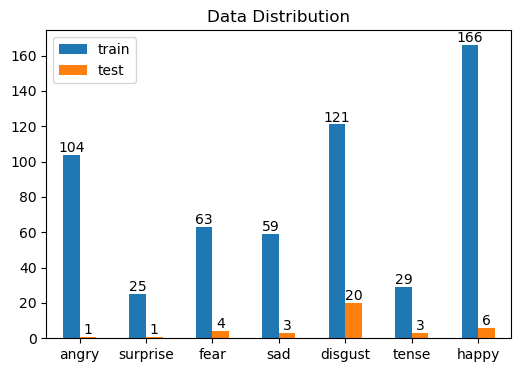

Ground Truth:	[4, 4, 4, 4, 5, 6, 4, 2, 0, 4, 4, 2, 2, 4, 4, 6, 6, 4, 4, 4, 4, 4, 4, 1, 6, 4, 5, 5, 6, 6, 3, 4, 4, 3, 3, 4, 2, 4]
Predicted:	[2, 4, 4, 5, 0, 6, 0, 0, 3, 2, 0, 4, 2, 1, 0, 2, 6, 0, 0, 2, 6, 5, 2, 0, 4, 2, 0, 2, 6, 6, 1, 2, 1, 0, 5, 1, 0, 4]
[OVERALL] Accuracy: 0.3882 | UF1 score: 0.2618 | UAR score: 0.2686
Subject (14/16): wangzishan


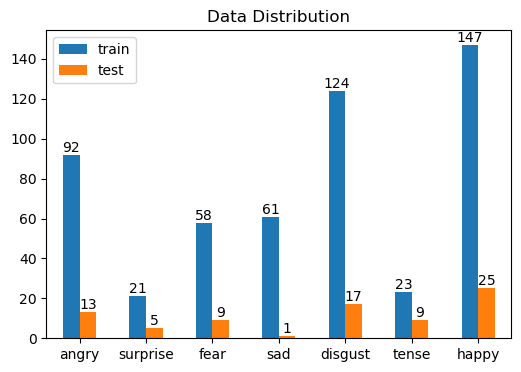

Ground Truth:	[6, 6, 0, 0, 6, 2, 2, 2, 5, 1, 5, 6, 4, 6, 6, 4, 6, 6, 6, 5, 2, 6, 2, 4, 2, 6, 0, 2, 6, 6, 0, 4, 4, 2, 5, 4, 4, 4, 0, 6, 4, 4, 6, 4, 5, 5, 2, 6, 1, 4, 6, 0, 4, 5, 6, 0, 0, 0, 1, 6, 6, 1, 1, 5, 0, 6, 6, 0, 6, 5, 0, 6, 4, 4, 4, 4, 3, 6, 0]
Predicted:	[6, 6, 4, 6, 6, 6, 6, 6, 0, 2, 4, 6, 4, 6, 6, 0, 6, 6, 6, 4, 4, 6, 6, 4, 6, 6, 6, 6, 6, 6, 0, 4, 4, 4, 6, 0, 6, 6, 4, 6, 6, 4, 6, 6, 2, 6, 6, 6, 6, 6, 6, 5, 4, 6, 6, 4, 4, 6, 6, 6, 6, 4, 4, 4, 4, 6, 6, 4, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 4]
[OVERALL] Accuracy: 0.3924 | UF1 score: 0.2526 | UAR score: 0.2614
Subject (15/16): xietao


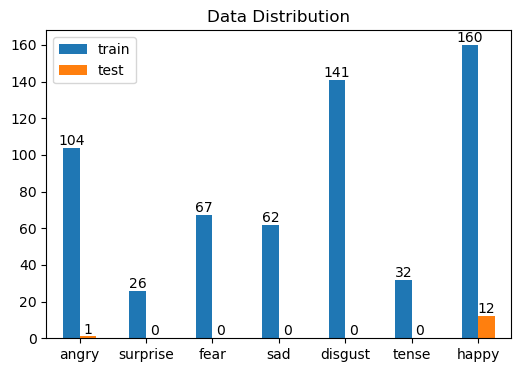

Ground Truth:	[6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Predicted:	[6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
[OVERALL] Accuracy: 0.4046 | UF1 score: 0.2552 | UAR score: 0.2631
Subject (16/16): wangshuai


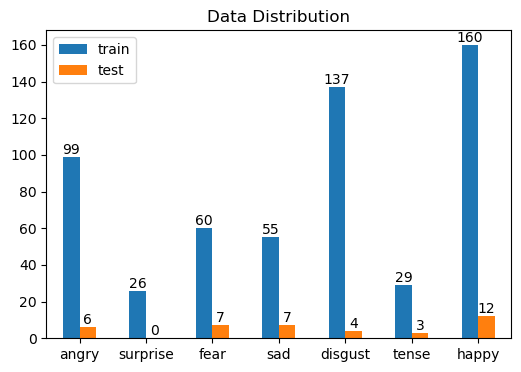

Ground Truth:	[2, 0, 3, 6, 3, 3, 3, 6, 6, 0, 6, 3, 6, 2, 6, 6, 2, 5, 2, 0, 3, 4, 0, 6, 6, 6, 0, 2, 6, 2, 6, 4, 4, 5, 3, 2, 0, 5, 4]
Predicted:	[6, 6, 6, 6, 4, 6, 0, 6, 6, 3, 6, 4, 6, 3, 4, 6, 4, 4, 4, 6, 4, 4, 0, 6, 6, 6, 4, 4, 6, 4, 6, 0, 6, 0, 6, 4, 4, 2, 6]
[OVERALL] Accuracy: 0.4000 | UF1 score: 0.2491 | UAR score: 0.2589


In [40]:
epoch = 200
lr = 0.001
batch_size = 128
out_dir = r'Data Distribution\Data Distribution loso'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

train_locosv(epoch, lr, batch_size, out_dir, label_emotions)

## 10foldcv

In [26]:
from sklearn.model_selection import KFold

def train_10foldcv(epochs, lr, batch_size, out_dir, label_emotions):
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)  # 创建10折交叉验证的实例
    subjects = list(set(dataset_TAIIC['subject']))
    dataset_indices = list(range(len(dataset_TAIIC['subject'])))  # 获取数据集索引列表

    # 用于保存所有折的评估结果
    actual = []
    predicted = []
    uf1_history = []
    uar_history = []
    accuracy_history = []
    num_correct = 0
    total_sample = 0
    cm_df = None
    
    f = open('Train results/FULL_logs_10fold.txt', 'a')

    for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset_indices)):
        print(f'Fold {fold + 1}/{10}')

        # 根据索引分割训练集和测试集
        train_X = [dataset_TAIIC['X'][i] for i in train_indices]
        train_y = [dataset_TAIIC['y'][i] for i in train_indices]
        test_X = [dataset_TAIIC['X'][i] for i in test_indices]
        test_y = [dataset_TAIIC['y'][i] for i in test_indices]
        
        # 将字符串的情绪类型转为数字
        train_y = get_numerical_labels(train_y)
        test_y = get_numerical_labels(test_y)

        train_loader = generate_dataloader(train_X, train_y, batch_size=batch_size)
        test_loader = generate_dataloader(test_X, test_y, batch_size=batch_size)

        model = MER().to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        
        # TRAINING
        model.train()
        
        for epoch in range(epochs):
            for batch, y in train_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                optimizer.zero_grad()
                y_hat = model.forward((os, h, v))
                loss = criterion(y_hat, y)

                loss.backward()
                optimizer.step()
                
        # TESTING
        model.eval()
        with torch.no_grad():
            y_preds = torch.Tensor().to(device)
            y_test = torch.Tensor().to(device)

            for batch, y in test_loader:
                batch = batch.to(device)
                y = y.to(device)

                os = batch[:, :1, :, :]
                h = batch[:, 1:2, :, :]
                v = batch[:, 2:, :, :]

                y_hat = model.forward((os, h, v))
                y_hat = torch.argmax(y_hat, dim=1)
                y_preds = torch.cat((y_preds, y_hat), dim=0)
                y_test = torch.cat((y_test, y), dim=0)
            
            y_test = y_test.to('cpu')
            y_preds = y_preds.to('cpu')
            f.write(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}\n')
            f.write(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}\n')
            print(f'Ground Truth:\t{[int(i) for i in y_test.tolist()]}')
            print(f'Predicted:\t{[int(i) for i in y_preds.tolist()]}')
            
            cm = confusion_matrix(y_test, y_preds, labels=range(7))
            if type(cm_df) != pd.DataFrame:
                cm_df = pd.DataFrame(cm, index=label_emotions, columns=label_emotions)
            else:
                cm_df = cm_df.add(pd.DataFrame(cm, index=label_emotions, columns=label_emotions))
            
            num_correct += (y_preds == y_test).sum().item()
            total_sample += len(y_test)
            accuracy = num_correct / total_sample
            accuracy_history.append(accuracy)

            actual.extend(y_test.tolist())
            predicted.extend(y_preds.tolist())

            uf1, uar = evaluation_metrics(actual, predicted, label_emotions)
            uf1_history.append(uf1)
            uar_history.append(uar)

            f.write(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}\n')
            f.write('=========================================================\n')
            print(f'[OVERALL] Accuracy: {accuracy:.4f} | UF1 score: {uf1:.4f} | UAR score: {uar:.4f}')
            print('=========================================================')

In [34]:
epoch = 200
lr = 0.001
batch_size = 64
out_dir = r'Data Distribution\Data Distribution kfold'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_10foldcv(epoch, lr, batch_size, out_dir, label_emotions)

Fold 1/10
Ground Truth:	[2, 0, 5, 6, 3, 6, 4, 4, 4, 5, 6, 0, 2, 4, 2, 1, 2, 0, 4, 6, 4, 6, 5, 4, 3, 4, 5, 6, 0, 3, 4, 0, 4, 5, 4, 4, 0, 0, 6, 0, 0, 4, 6, 3, 6, 6, 3, 1, 3, 5, 0, 0, 6, 6, 4, 0, 6, 3, 4, 2, 5]
Predicted:	[2, 4, 0, 6, 3, 6, 4, 4, 4, 1, 0, 0, 5, 0, 6, 0, 2, 0, 2, 6, 4, 6, 6, 4, 4, 4, 5, 6, 4, 3, 4, 4, 4, 5, 4, 4, 0, 0, 6, 0, 4, 4, 6, 3, 6, 6, 3, 1, 3, 2, 4, 4, 6, 6, 4, 0, 6, 3, 4, 5, 2]
[OVERALL] Accuracy: 0.6885 | UF1 score: 0.6234 | UAR score: 0.6189
Fold 2/10
Ground Truth:	[2, 0, 5, 2, 6, 2, 4, 4, 4, 5, 6, 0, 2, 4, 2, 3, 2, 0, 4, 6, 4, 2, 1, 4, 6, 4, 3, 6, 0, 6, 4, 0, 4, 1, 4, 4, 0, 0, 2, 0, 0, 0, 6, 6, 6, 2, 6, 3, 6, 3, 0, 0, 2, 2, 4, 0, 2, 6, 4, 2, 1]
Predicted:	[0, 3, 3, 4, 4, 2, 6, 4, 4, 1, 6, 0, 2, 4, 2, 0, 2, 6, 4, 6, 4, 4, 0, 4, 6, 0, 4, 0, 4, 4, 4, 0, 4, 1, 4, 4, 0, 0, 6, 0, 0, 0, 6, 6, 0, 6, 6, 0, 6, 3, 0, 4, 2, 2, 4, 5, 4, 6, 5, 6, 1]
[OVERALL] Accuracy: 0.6393 | UF1 score: 0.5934 | UAR score: 0.5844
Fold 3/10
Ground Truth:	[2, 0, 5, 6, 6, 6, 4, 4, 4, 5, 6, 0,